In [1]:
import tensorflow as tf 
import numpy as np 
from tensorflow import keras 
import os 
import math 
import random 
import pickle 
import glob
import matplotlib.pyplot as plt 
from collections import deque 
from tensorflow.keras import layers
import time 
import scipy.io as sio

from vehicle_model_variant import Environment 
from cell_model import CellModel 
from driver_MDP import Driver_MDP 

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
drving_cycle = '../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat'
battery_path = "../../OC_SIM_DB/OC_SIM_DB_Bat/OC_SIM_DB_Bat_nimh_6_240_panasonic_MY01_Prius.mat"
motor_path = "../../OC_SIM_DB/OC_SIM_DB_Mot/OC_SIM_DB_Mot_pm_95_145_X2.mat"
cell_model = CellModel()
# env = Environment(cell_model, drving_cycle, battery_path, motor_path, 10)
driver = Driver_MDP(0.02)

num_states = 4

In [3]:
class OUActionNoise: 
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None): 
        self.theta = theta 
        self.mean = mean 
        self.std_dev = std_deviation 
        self.dt = dt 
        self.x_initial = x_initial 
        self.reset() 
        
    def reset(self): 
        if self.x_initial is not None: 
            self.x_prev = self.x_initial 
        else: 
            self.x_prev = 0 
            
    def __call__(self): 
        x = (
             self.x_prev + self.theta * (self.mean - self.x_prev) * self.dt 
            + self.std_dev * np.sqrt(self.dt) * np.random.normal() 
        )
        self.x_prev = x 
        return x 

In [4]:
class Buffer: 
    def __init__(self, buffer_capacity=100000, batch_size=64):      
        self.buffer_capacity = buffer_capacity 
        self.batch_size = batch_size 
        self.buffer_counter = 0 
        
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, 1))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        
    def record(self, obs_tuple):
        index = self.buffer_counter % self.buffer_capacity 

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        
        self.buffer_counter += 1 
        
    def learn(self): 
        record_range = min(self.buffer_counter, self.buffer_capacity)
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        
        with tf.GradientTape() as tape: 
            target_actions = target_actor(next_state_batch)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions])
            critic_value = critic_model([state_batch, action_batch])
            critic_loss = tf.math.reduce_mean(tf.square(y - critic_value)) 
        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables) 
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )
        
        with tf.GradientTape() as tape: 
            actions = actor_model(state_batch)
            critic_value = critic_model([state_batch, actions])
            actor_loss = - tf.math.reduce_mean(critic_value)
        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables) 
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )
        

In [5]:
def update_target(tau): 
    new_weights = [] 
    target_variables = target_critic.weights
    for i, variable in enumerate(critic_model.weights): 
        new_weights.append(target_variables[i] * (1 - tau) + tau * variable)
    target_critic.set_weights(new_weights)
    
    new_weights = [] 
    target_variables = target_actor.weights
    for i, variable in enumerate(actor_model.weights): 
        new_weights.append(target_variables[i] * (1 - tau) + tau * variable)
    target_actor.set_weights(new_weights)
    

In [6]:
def get_actor(): 
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    
    inputs = layers.Input(shape=(num_states))
    inputs_batchnorm = layers.BatchNormalization()(inputs)
    
    out = layers.Dense(512, activation="relu")(inputs_batchnorm)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1, activation="sigmoid", 
                          kernel_initializer=last_init)(out)
    model = tf.keras.Model(inputs, outputs)
    return model

In [7]:
def get_critic(): 
    state_input = layers.Input(shape=(num_states))
    state_input_batchnorm = layers.BatchNormalization()(state_input)
    
    state_out = layers.Dense(16, activation="relu")(state_input_batchnorm)
#     state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(32, activation="relu")(state_out)
#     state_out = layers.BatchNormalization()(state_out)
    
    action_input = layers.Input(shape=(1))
    action_out = layers.Dense(32, activation="relu")(action_input)
#     action_out = layers.BatchNormalization()(action_out)
    
    concat = layers.Concatenate()([state_out, action_out]) 
    
    out = layers.Dense(512, activation="relu")(concat)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1)(out)
    
    model = tf.keras.Model([state_input, action_input], outputs)
    return model 
    

In [8]:
def policy(state, noise_object): 
    j_min = state[0][2].numpy()
    j_max = state[0][3].numpy()
    sampled_action = tf.squeeze(actor_model(state)) 
    noise = noise_object()
    sampled_action = sampled_action.numpy() + noise 
    legal_action = sampled_action * j_max 
    legal_action = np.clip(legal_action, j_min, j_max)
#     print(j_min, j_max, legal_action, noise)
    return legal_action 
    

In [9]:
def policy_epsilon_greedy(state, eps): 
    j_min = state[0][-2].numpy()
    j_max = state[0][-1].numpy()

    if random.random() < eps: 
        a = random.randint(0, 9)
        return np.linspace(j_min, j_max, 10)[a]
    else: 
        sampled_action = tf.squeeze(actor_model(state)).numpy()  
        legal_action = sampled_action * j_max 
        legal_action = np.clip(legal_action, j_min, j_max)
        return legal_action

In [10]:
std_dev = 0.2 
ou_noise = OUActionNoise(mean=0, std_deviation=0.2)

critic_lr = 0.0005 
actor_lr = 0.00025 
critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 400
gamma = 0.95 
tau = 0.001 

MAX_EPSILON = 1.0 
MIN_EPSILON = 0.01 
DECAY_RATE = 0.00002
BATCH_SIZE = 32 
DELAY_TRAINING = 3000 

In [11]:
def initialization(): 
    actor_model = get_actor() 
    critic_model = get_critic() 
    target_actor = get_actor() 
    target_critic = get_critic() 
    target_actor.set_weights(actor_model.get_weights())
    target_critic.set_weights(critic_model.get_weights())
#     actor_model.load_weights("./DDPG1_trial1/actor_model_checkpoint")
#     critic_model.load_weights("./DDPG1_trial1/critic_model_checkpoint")
#     target_actor.load_weights("./DDPG1_trial1/target_actor_checkpoint")
#     target_critic.load_weights("./DDPG1_trial1/target_critic_checkpoint")
    
    buffer = Buffer(500000, BATCH_SIZE)
    return actor_model, critic_model, target_actor, target_critic, buffer

In [12]:
def save_weights(actor_model, critic_model, target_actor, target_critic, root): 
    if not os.path.exists(root): 
        os.makedirs(root)
    
    actor_model.save_weights("./{}/actor_model.h5".format(root))
    critic_model.save_weights("./{}/critic_model.h5".format(root))
    target_actor.save_weights("./{}/target_actor.h5".format(root))
    target_critic.save_weights("./{}/target_critic.h5".format(root))
    print("model is saved..")

In [13]:
def initialization_env(driving_path, reward_factor):
    env = Environment(cell_model, driving_path, battery_path, motor_path, reward_factor)
    return env 

In [14]:
def test_agent(actor_model, reward_factor):
    test_cycle = driver.get_cycle() 
    env = initialization_env(test_cycle, reward_factor)
    
    total_reward = 0
    state = env.reset() 
    while True: 
        tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        action = policy_epsilon_greedy(tf_state, -1)
        next_state, reward, done = env.step(action)
        
        state = next_state 
        total_reward += reward 
        
        if done: 
            break 
        
    SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
    
    print("******************* Test is start *****************")
#     print(test_cycle)
    print('Total reward: {}'.format(total_reward), 
          "SOC: {:.4f}".format(env.SOC), 
          "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
          "Fuel Consumption: {:.4f}".format(env.fuel_consumption))
    print("******************* Test is done *****************")
    print("")
    plt.subplot(1, 2, 1)
    plt.plot(test_cycle)
    plt.subplot(1, 2, 2)
    plt.plot(env.history["Action"])
    plt.show() 
    return env.history  
    


Trial 0

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 10.027
Episode: 1 Exploration P: 1.0000 Total reward: -5082.226250487994 SOC: 1.0000 Cumulative_SOC_deviation: 492.7804 Fuel Consumption: 154.4224

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 7.491
Episode: 2 Exploration P: 1.0000 Total reward: -3881.946084991509 SOC: 1.0000 Cumulative_SOC_deviation: 376.0214 Fuel Consumption: 121.7319

../data/driving_cycles/city\07_manhattan.mat

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocas

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -1231.225719464238 SOC: 0.3425 Cumulative_SOC_deviation: 122.7224 Fuel Consumption: 4.0015
******************* Test is done *****************



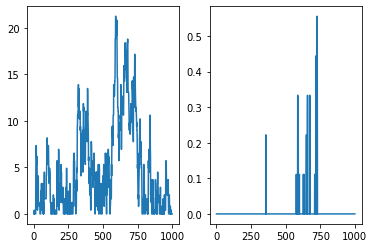

../data/driving_cycles/city\VITO_RW_BUS_TMB_Line24N_1.mat
maximum steps, simulation is done ... 
elapsed_time: 171.656
Episode: 11 Exploration P: 0.7972 Total reward: -11442.26480314537 SOC: 1.0000 Cumulative_SOC_deviation: 1121.3435 Fuel Consumption: 228.8293

../data/driving_cycles/city\VITO_RW_BUS_VH_Brussels_Empty_1.mat
maximum steps, simulation is done ... 
elapsed_time: 125.441
Episode: 12 Exploration P: 0.7645 Total reward: -7899.482546951879 SOC: 1.0000 Cumulative_SOC_deviation: 773.7976 Fuel Consumption: 161.5070

../data/driving_cycles/city\VITO_RW_BUS_VH_Brussels_Full_1.mat
maximum steps, simulation is done ... 
elapsed_time: 155.726
Episode: 13 Exploration P: 0.7260 Total reward: -9999.049512894953 SOC: 1.0000 Cumulative_SOC_deviation: 980.9432 Fuel Consumption: 189.6177

../data/driving_cycles/city\VITO_RW_BUS_VH_Brussels_Medium_1.mat
maximum steps, simulation is done ... 
elapsed_time: 133.142
Episode: 14 Exploration P: 0.6942 Total reward: -8332.103206667289 SOC: 1.0000 

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -1011.9426664631513 SOC: 0.4052 Cumulative_SOC_deviation: 101.0820 Fuel Consumption: 1.1227
******************* Test is done *****************



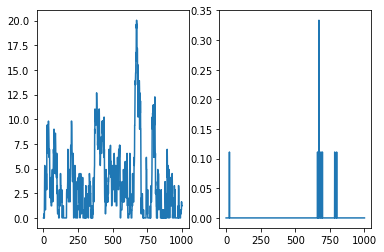

../data/driving_cycles/city\VITO_RW_Kangoo_DePost_Brussels_101_1.mat
maximum steps, simulation is done ... 
elapsed_time: 195.054
Episode: 21 Exploration P: 0.5305 Total reward: -9893.994068201624 SOC: 1.0000 Cumulative_SOC_deviation: 974.9765 Fuel Consumption: 144.2288

../data/driving_cycles/city\wvucity.mat
maximum steps, simulation is done ... 
elapsed_time: 83.992
Episode: 22 Exploration P: 0.5160 Total reward: -4903.033328765554 SOC: 1.0000 Cumulative_SOC_deviation: 482.5006 Fuel Consumption: 78.0272

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 81.133
Episode: 23 Exploration P: 0.5023 Total reward: -3794.043410636686 SOC: 1.0000 Cumulative_SOC_deviation: 369.6763 Fuel Consumption: 97.2806

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 63.726
Episode: 24 Exploration P: 0.4920 Total reward: -2848.205223737798 SOC: 0.9810 Cumulative_SOC_deviation: 277.1099 Fuel Consumption: 77

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


battery power is 105409.2105419473(+) but condition is not avail
******************* Test is start *****************
Total reward: -1028.9515719695526 SOC: 0.5101 Cumulative_SOC_deviation: 2.8178 Fuel Consumption: 1.6729
******************* Test is done *****************



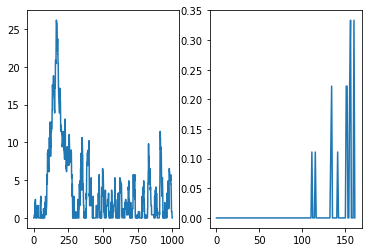

../data/driving_cycles/city\VITO_MOLCity.mat
maximum steps, simulation is done ... 
elapsed_time: 123.860
Episode: 31 Exploration P: 0.4202 Total reward: -4753.8980361983495 SOC: 0.9639 Cumulative_SOC_deviation: 467.6211 Fuel Consumption: 77.6874

../data/driving_cycles/city\VITO_RW_Antwerp1_May19c.mat
maximum steps, simulation is done ... 
elapsed_time: 89.159
Episode: 32 Exploration P: 0.4119 Total reward: -2790.688173440615 SOC: 1.0000 Cumulative_SOC_deviation: 274.0812 Fuel Consumption: 49.8761

../data/driving_cycles/city\VITO_RW_BUS_TMB_Line24N_1.mat
maximum steps, simulation is done ... 
elapsed_time: 252.730
Episode: 33 Exploration P: 0.3889 Total reward: -10445.194066995668 SOC: 1.0000 Cumulative_SOC_deviation: 1033.0896 Fuel Consumption: 114.2980

../data/driving_cycles/city\VITO_RW_BUS_VH_Brussels_Empty_1.mat
maximum steps, simulation is done ... 
elapsed_time: 175.753
Episode: 34 Exploration P: 0.3732 Total reward: -6398.850529824794 SOC: 1.0000 Cumulative_SOC_deviation: 63

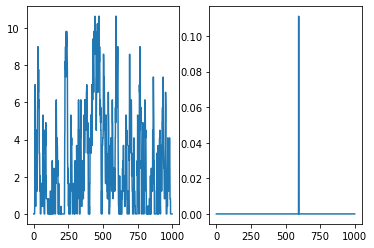

../data/driving_cycles/city\VITO_RW_Decade_Polo_BCN_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 117.424
Episode: 41 Exploration P: 0.2886 Total reward: -3311.84043380819 SOC: 1.0000 Cumulative_SOC_deviation: 325.1065 Fuel Consumption: 60.7758

../data/driving_cycles/city\VITO_RW_Jumper_Brussels_101_1.mat
maximum steps, simulation is done ... 
elapsed_time: 217.253
Episode: 42 Exploration P: 0.2744 Total reward: -8305.93361211364 SOC: 1.0000 Cumulative_SOC_deviation: 822.4419 Fuel Consumption: 81.5146

../data/driving_cycles/city\VITO_RW_Kangoo_DePost_Brussels_101_1.mat
maximum steps, simulation is done ... 
elapsed_time: 219.509
Episode: 43 Exploration P: 0.2605 Total reward: -8331.042029241922 SOC: 1.0000 Cumulative_SOC_deviation: 825.0280 Fuel Consumption: 80.7619

../data/driving_cycles/city\wvucity.mat
maximum steps, simulation is done ... 
elapsed_time: 115.768
Episode: 44 Exploration P: 0.2536 Total reward: -3275.554925466456 SOC: 1.0000 Cumulative_SOC_deviatio

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -754.7099036892272 SOC: 0.4491 Cumulative_SOC_deviation: 75.4330 Fuel Consumption: 0.3798
******************* Test is done *****************



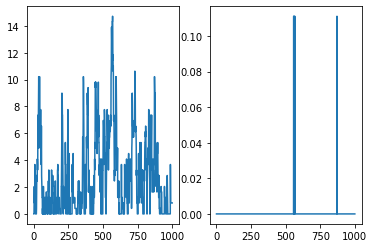

../data/driving_cycles/city\ny_city_traffic.mat
maximum steps, simulation is done ... 
elapsed_time: 35.063
Episode: 51 Exploration P: 0.2171 Total reward: -677.3943874976841 SOC: 0.8207 Cumulative_SOC_deviation: 65.3503 Fuel Consumption: 23.8915

../data/driving_cycles/city\VITO_DUBDC.mat
maximum steps, simulation is done ... 
elapsed_time: 53.148
Episode: 52 Exploration P: 0.2134 Total reward: -371.9589902002023 SOC: 0.6945 Cumulative_SOC_deviation: 34.3319 Fuel Consumption: 28.6403

../data/driving_cycles/city\VITO_MOLCity.mat
maximum steps, simulation is done ... 
elapsed_time: 88.063
Episode: 53 Exploration P: 0.2075 Total reward: -1928.9454452800785 SOC: 0.7633 Cumulative_SOC_deviation: 187.9282 Fuel Consumption: 49.6633

../data/driving_cycles/city\VITO_RW_Antwerp1_May19c.mat
maximum steps, simulation is done ... 
elapsed_time: 61.682
Episode: 54 Exploration P: 0.2035 Total reward: -1767.9164184046842 SOC: 0.9016 Cumulative_SOC_deviation: 173.1505 Fuel Consumption: 36.4110

../d

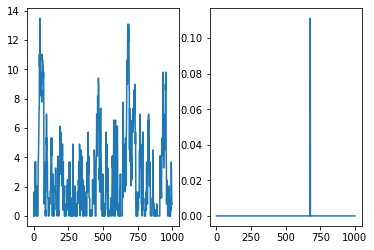

../data/driving_cycles/city\VITO_RW_Decade_Octavia_BCN_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 96.141
Episode: 61 Exploration P: 0.1523 Total reward: -1774.6951309030999 SOC: 0.8031 Cumulative_SOC_deviation: 173.5999 Fuel Consumption: 38.6962

../data/driving_cycles/city\VITO_RW_Decade_Octavia_MOL_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 89.797
Episode: 62 Exploration P: 0.1481 Total reward: -699.5458168013411 SOC: 0.4918 Cumulative_SOC_deviation: 66.4514 Fuel Consumption: 35.0323

../data/driving_cycles/city\VITO_RW_Decade_Polo_BCN_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 88.619
Episode: 63 Exploration P: 0.1441 Total reward: -289.2298505319105 SOC: 0.5821 Cumulative_SOC_deviation: 25.9749 Fuel Consumption: 29.4809

../data/driving_cycles/city\VITO_RW_Jumper_Brussels_101_1.mat
maximum steps, simulation is done ... 
elapsed_time: 173.547
Episode: 64 Exploration P: 0.1372 Total reward: -4196.1162735664375 SOC: 0.9001 Cum

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (


maximum steps, simulation is done ... 
elapsed_time: 63.182
Episode: 68 Exploration P: 0.1217 Total reward: -1841.3536076174544 SOC: 0.1997 Cumulative_SOC_deviation: 181.9016 Fuel Consumption: 22.3373

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 95.807
Episode: 69 Exploration P: 0.1193 Total reward: -453.3877311082921 SOC: 0.6926 Cumulative_SOC_deviation: 43.4847 Fuel Consumption: 18.5405

../data/driving_cycles/city\FTP_75_cycle.mat


C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 180.937
Episode: 70 Exploration P: 0.1152 Total reward: -6041.708815103424 SOC: 0.0187 Cumulative_SOC_deviation: 599.6591 Fuel Consumption: 45.1173

maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -2007.3747110578995 SOC: 0.2951 Cumulative_SOC_deviation: 199.9844 Fuel Consumption: 7.5308
******************* Test is done *****************



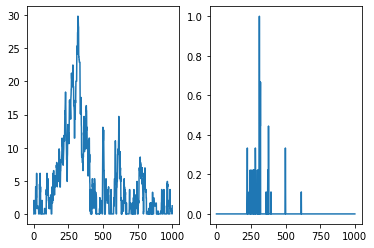

../data/driving_cycles/city\nuremberg_r36.mat
maximum steps, simulation is done ... 
elapsed_time: 104.427
Episode: 71 Exploration P: 0.1130 Total reward: -675.1301536372704 SOC: 0.6621 Cumulative_SOC_deviation: 65.5863 Fuel Consumption: 19.2673

../data/driving_cycles/city\ny_city_composite_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 106.409
Episode: 72 Exploration P: 0.1109 Total reward: -440.4139463132711 SOC: 0.6356 Cumulative_SOC_deviation: 42.4889 Fuel Consumption: 15.5248

../data/driving_cycles/city\ny_city_traffic.mat
maximum steps, simulation is done ... 
elapsed_time: 56.326
Episode: 73 Exploration P: 0.1097 Total reward: -148.6456043827973 SOC: 0.6399 Cumulative_SOC_deviation: 13.8960 Fuel Consumption: 9.6858

../data/driving_cycles/city\VITO_DUBDC.mat
maximum steps, simulation is done ... 
elapsed_time: 59.652
Episode: 74 Exploration P: 0.1079 Total reward: -165.68516074042702 SOC: 0.6215 Cumulative_SOC_deviation: 14.3728 Fuel Consumption: 21.9576

../da

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -56.40410761519136 SOC: 0.5936 Cumulative_SOC_deviation: 4.7874 Fuel Consumption: 8.5305
******************* Test is done *****************



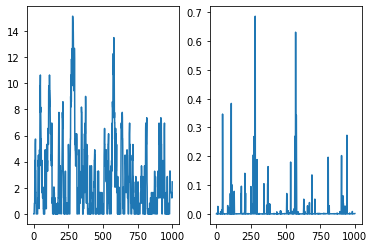

../data/driving_cycles/city\VITO_RW_Decade_Jumper_BCN_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 107.903
Episode: 81 Exploration P: 0.0837 Total reward: -277.5666621170065 SOC: 0.6366 Cumulative_SOC_deviation: 25.0912 Fuel Consumption: 26.6548

../data/driving_cycles/city\VITO_RW_Decade_Jumper_MOL_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 121.418
Episode: 82 Exploration P: 0.0808 Total reward: -187.14534296851937 SOC: 0.6069 Cumulative_SOC_deviation: 15.3807 Fuel Consumption: 33.3380

../data/driving_cycles/city\VITO_RW_Decade_Octavia_BCN_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 101.131
Episode: 83 Exploration P: 0.0785 Total reward: -168.14459448207214 SOC: 0.6147 Cumulative_SOC_deviation: 14.4825 Fuel Consumption: 23.3192

../data/driving_cycles/city\VITO_RW_Decade_Octavia_MOL_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 93.721
Episode: 84 Exploration P: 0.0765 Total reward: -100.15430586080262 SOC: 0.60

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -105.13449132050151 SOC: 0.5915 Cumulative_SOC_deviation: 9.1068 Fuel Consumption: 14.0663
******************* Test is done *****************



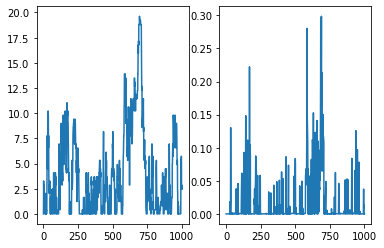

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 64.427
Episode: 91 Exploration P: 0.0626 Total reward: -90.08082784548755 SOC: 0.5921 Cumulative_SOC_deviation: 7.9778 Fuel Consumption: 10.3023

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 111.470
Episode: 92 Exploration P: 0.0607 Total reward: -176.10351226204668 SOC: 0.6100 Cumulative_SOC_deviation: 10.0895 Fuel Consumption: 75.2081

../data/driving_cycles/city\nuremberg_r36.mat
maximum steps, simulation is done ... 
elapsed_time: 63.502
Episode: 93 Exploration P: 0.0596 Total reward: -103.41482569347917 SOC: 0.6087 Cumulative_SOC_deviation: 8.9093 Fuel Consumption: 14.3221

../data/driving_cycles/city\ny_city_composite_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 59.753
Episode: 94 Exploration P: 0.0586 Total reward: -152.02354924340912 SOC: 0.6225 Cumulative_SOC_deviation: 13.8111 Fuel Consumption: 13.9124

../dat

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -85.6016580229159 SOC: 0.5932 Cumulative_SOC_deviation: 7.1796 Fuel Consumption: 13.8058
******************* Test is done *****************



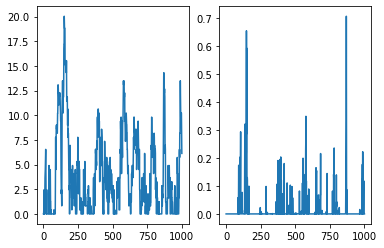

../data/driving_cycles/city\VITO_RW_BUS_VH_Brussels_Full_1.mat
maximum steps, simulation is done ... 
elapsed_time: 152.268
Episode: 101 Exploration P: 0.0484 Total reward: -200.81697793090967 SOC: 0.6103 Cumulative_SOC_deviation: 16.4426 Fuel Consumption: 36.3906

../data/driving_cycles/city\VITO_RW_BUS_VH_Brussels_Medium_1.mat
maximum steps, simulation is done ... 
elapsed_time: 131.444
Episode: 102 Exploration P: 0.0467 Total reward: -134.50135984245236 SOC: 0.6029 Cumulative_SOC_deviation: 9.9090 Fuel Consumption: 35.4112

../data/driving_cycles/city\VITO_RW_Decade_Jumper_BCN_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 101.876
Episode: 103 Exploration P: 0.0455 Total reward: -86.30372205283952 SOC: 0.6002 Cumulative_SOC_deviation: 6.4145 Fuel Consumption: 22.1589

../data/driving_cycles/city\VITO_RW_Decade_Jumper_MOL_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 116.098
Episode: 104 Exploration P: 0.0441 Total reward: -125.84569425449003 SOC: 0.5

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -58.22337058761358 SOC: 0.5932 Cumulative_SOC_deviation: 4.2276 Fuel Consumption: 15.9469
******************* Test is done *****************



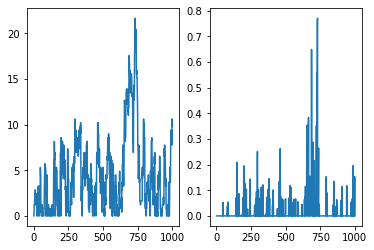

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 78.674
Episode: 111 Exploration P: 0.0364 Total reward: -118.51617440143654 SOC: 0.6003 Cumulative_SOC_deviation: 7.3030 Fuel Consumption: 45.4862

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 61.672
Episode: 112 Exploration P: 0.0359 Total reward: -154.15322757814343 SOC: 0.6169 Cumulative_SOC_deviation: 11.0585 Fuel Consumption: 43.5681

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 62.942
Episode: 113 Exploration P: 0.0353 Total reward: -47.00325655696363 SOC: 0.6003 Cumulative_SOC_deviation: 3.7263 Fuel Consumption: 9.7401

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 123.561
Episode: 114 Exploration P: 0.0344 Total reward: -180.79475547286086 SOC: 0.6064 Cumulative_SOC_deviation: 10.7439 Fuel Consumption: 73.3554

../data/drivi

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -102.92268994477573 SOC: 0.5902 Cumulative_SOC_deviation: 8.8441 Fuel Consumption: 14.4821
******************* Test is done *****************



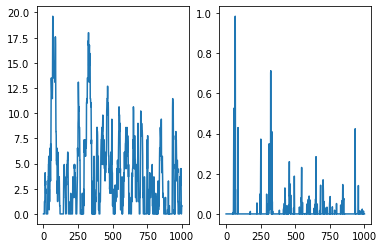

../data/driving_cycles/city\VITO_RW_BUS_TMB_Line24N_1.mat
maximum steps, simulation is done ... 
elapsed_time: 273.620
Episode: 121 Exploration P: 0.0303 Total reward: -198.2348424456097 SOC: 0.6019 Cumulative_SOC_deviation: 17.5851 Fuel Consumption: 22.3837

../data/driving_cycles/city\VITO_RW_BUS_VH_Brussels_Empty_1.mat
maximum steps, simulation is done ... 
elapsed_time: 195.147
Episode: 122 Exploration P: 0.0295 Total reward: -132.8432564095039 SOC: 0.5992 Cumulative_SOC_deviation: 9.6533 Fuel Consumption: 36.3102

../data/driving_cycles/city\VITO_RW_BUS_VH_Brussels_Full_1.mat
maximum steps, simulation is done ... 
elapsed_time: 176.100
Episode: 123 Exploration P: 0.0285 Total reward: -151.57818535942033 SOC: 0.5930 Cumulative_SOC_deviation: 11.7768 Fuel Consumption: 33.8104

../data/driving_cycles/city\VITO_RW_BUS_VH_Brussels_Medium_1.mat
maximum steps, simulation is done ... 
elapsed_time: 151.085
Episode: 124 Exploration P: 0.0277 Total reward: -175.52582185421707 SOC: 0.5935 Cu

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -56.00110185012908 SOC: 0.5954 Cumulative_SOC_deviation: 4.4467 Fuel Consumption: 11.5343
******************* Test is done *****************



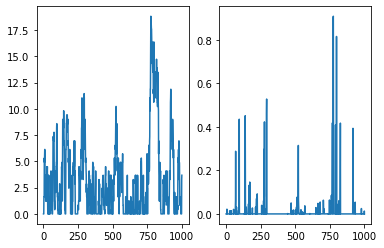

../data/driving_cycles/city\VITO_RW_Kangoo_DePost_Brussels_101_1.mat
maximum steps, simulation is done ... 
elapsed_time: 175.487
Episode: 131 Exploration P: 0.0234 Total reward: -210.74976309312078 SOC: 0.5987 Cumulative_SOC_deviation: 18.2854 Fuel Consumption: 27.8954

../data/driving_cycles/city\wvucity.mat
maximum steps, simulation is done ... 
elapsed_time: 113.394
Episode: 132 Exploration P: 0.0231 Total reward: -121.29137358929304 SOC: 0.5897 Cumulative_SOC_deviation: 10.6781 Fuel Consumption: 14.5099

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 113.174
Episode: 133 Exploration P: 0.0227 Total reward: -162.42167682164623 SOC: 0.5956 Cumulative_SOC_deviation: 11.7020 Fuel Consumption: 45.4021

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 85.634
Episode: 134 Exploration P: 0.0225 Total reward: -117.68241693602596 SOC: 0.6059 Cumulative_SOC_deviation: 7.5302 Fuel Consumption

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -79.55579797723703 SOC: 0.5972 Cumulative_SOC_deviation: 6.1132 Fuel Consumption: 18.4240
******************* Test is done *****************



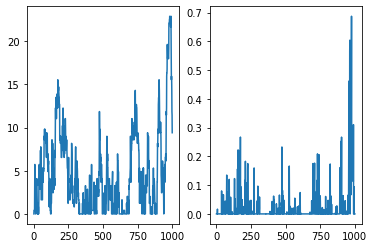

../data/driving_cycles/city\VITO_MOLCity.mat
maximum steps, simulation is done ... 
elapsed_time: 103.804
Episode: 141 Exploration P: 0.0206 Total reward: -105.664267289366 SOC: 0.5994 Cumulative_SOC_deviation: 7.5066 Fuel Consumption: 30.5982

../data/driving_cycles/city\VITO_RW_Antwerp1_May19c.mat
maximum steps, simulation is done ... 
elapsed_time: 79.937
Episode: 142 Exploration P: 0.0204 Total reward: -83.58465808654383 SOC: 0.5922 Cumulative_SOC_deviation: 7.2509 Fuel Consumption: 11.0754

../data/driving_cycles/city\VITO_RW_BUS_TMB_Line24N_1.mat
maximum steps, simulation is done ... 
elapsed_time: 186.285
Episode: 143 Exploration P: 0.0198 Total reward: -259.27179926696243 SOC: 0.5952 Cumulative_SOC_deviation: 23.7550 Fuel Consumption: 21.7217

../data/driving_cycles/city\VITO_RW_BUS_VH_Brussels_Empty_1.mat
maximum steps, simulation is done ... 
elapsed_time: 122.780
Episode: 144 Exploration P: 0.0194 Total reward: -215.56843611921568 SOC: 0.5856 Cumulative_SOC_deviation: 18.113

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -55.199776257317325 SOC: 0.5951 Cumulative_SOC_deviation: 3.1244 Fuel Consumption: 23.9561
******************* Test is done *****************



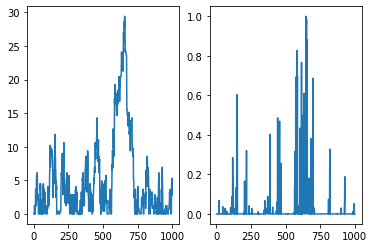

../data/driving_cycles/city\VITO_RW_Decade_Polo_BCN_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 85.047
Episode: 151 Exploration P: 0.0172 Total reward: -119.06080628244203 SOC: 0.5936 Cumulative_SOC_deviation: 9.4322 Fuel Consumption: 24.7393

../data/driving_cycles/city\VITO_RW_Jumper_Brussels_101_1.mat
maximum steps, simulation is done ... 
elapsed_time: 153.259
Episode: 152 Exploration P: 0.0168 Total reward: -190.7588164400778 SOC: 0.6006 Cumulative_SOC_deviation: 16.5852 Fuel Consumption: 24.9066

../data/driving_cycles/city\VITO_RW_Kangoo_DePost_Brussels_101_1.mat
maximum steps, simulation is done ... 
elapsed_time: 157.494
Episode: 153 Exploration P: 0.0165 Total reward: -170.6705382373995 SOC: 0.5931 Cumulative_SOC_deviation: 14.4014 Fuel Consumption: 26.6561

../data/driving_cycles/city\wvucity.mat
maximum steps, simulation is done ... 
elapsed_time: 81.700
Episode: 154 Exploration P: 0.0163 Total reward: -108.06093059730951 SOC: 0.5949 Cumulative_SOC_deviat

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -111.55457551245603 SOC: 0.6030 Cumulative_SOC_deviation: 7.7223 Fuel Consumption: 34.3317
******************* Test is done *****************



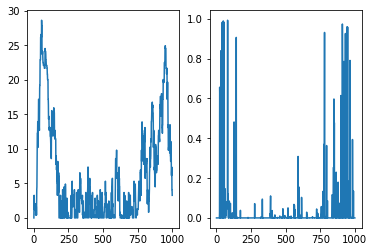

../data/driving_cycles/city\ny_city_traffic.mat
maximum steps, simulation is done ... 
elapsed_time: 31.315
Episode: 161 Exploration P: 0.0154 Total reward: -44.059593321616994 SOC: 0.5963 Cumulative_SOC_deviation: 3.8511 Fuel Consumption: 5.5486

../data/driving_cycles/city\VITO_DUBDC.mat
maximum steps, simulation is done ... 
elapsed_time: 48.492
Episode: 162 Exploration P: 0.0153 Total reward: -80.25023614765747 SOC: 0.6001 Cumulative_SOC_deviation: 6.2233 Fuel Consumption: 18.0172

../data/driving_cycles/city\VITO_MOLCity.mat
maximum steps, simulation is done ... 
elapsed_time: 79.570
Episode: 163 Exploration P: 0.0151 Total reward: -129.2725886283018 SOC: 0.6096 Cumulative_SOC_deviation: 9.8296 Fuel Consumption: 30.9764

../data/driving_cycles/city\VITO_RW_Antwerp1_May19c.mat
maximum steps, simulation is done ... 
elapsed_time: 55.113
Episode: 164 Exploration P: 0.0150 Total reward: -78.46697917795483 SOC: 0.5940 Cumulative_SOC_deviation: 6.7757 Fuel Consumption: 10.7098

../data/

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -82.64667809944497 SOC: 0.5922 Cumulative_SOC_deviation: 5.9124 Fuel Consumption: 23.5223
******************* Test is done *****************



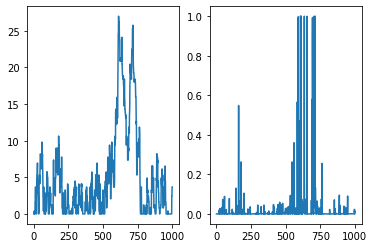

../data/driving_cycles/city\VITO_RW_Decade_Octavia_BCN_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 78.966
Episode: 171 Exploration P: 0.0137 Total reward: -105.41713037361707 SOC: 0.6016 Cumulative_SOC_deviation: 8.5647 Fuel Consumption: 19.7703

../data/driving_cycles/city\VITO_RW_Decade_Octavia_MOL_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 73.703
Episode: 172 Exploration P: 0.0136 Total reward: -119.30468779547985 SOC: 0.5911 Cumulative_SOC_deviation: 8.4818 Fuel Consumption: 34.4871

../data/driving_cycles/city\VITO_RW_Decade_Polo_BCN_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 71.821
Episode: 173 Exploration P: 0.0135 Total reward: -171.20829244838123 SOC: 0.5965 Cumulative_SOC_deviation: 14.6348 Fuel Consumption: 24.8604

../data/driving_cycles/city\VITO_RW_Jumper_Brussels_101_1.mat
maximum steps, simulation is done ... 
elapsed_time: 127.248
Episode: 174 Exploration P: 0.0133 Total reward: -144.59356331737973 SOC: 0.5926 

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -44.67542185595069 SOC: 0.5956 Cumulative_SOC_deviation: 2.6613 Fuel Consumption: 18.0622
******************* Test is done *****************



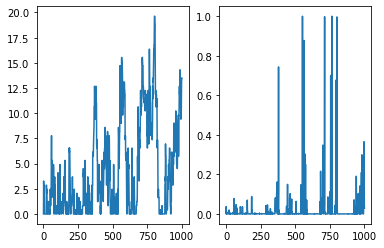

../data/driving_cycles/city\nuremberg_r36.mat
maximum steps, simulation is done ... 
elapsed_time: 52.209
Episode: 181 Exploration P: 0.0127 Total reward: -51.79441315589581 SOC: 0.6002 Cumulative_SOC_deviation: 3.9528 Fuel Consumption: 12.2666

../data/driving_cycles/city\ny_city_composite_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 49.036
Episode: 182 Exploration P: 0.0126 Total reward: -59.40470618008966 SOC: 0.6021 Cumulative_SOC_deviation: 4.8162 Fuel Consumption: 11.2431

../data/driving_cycles/city\ny_city_traffic.mat
maximum steps, simulation is done ... 
elapsed_time: 28.986
Episode: 183 Exploration P: 0.0126 Total reward: -26.64227348016541 SOC: 0.5966 Cumulative_SOC_deviation: 2.1132 Fuel Consumption: 5.5103

../data/driving_cycles/city\VITO_DUBDC.mat
maximum steps, simulation is done ... 
elapsed_time: 43.314
Episode: 184 Exploration P: 0.0125 Total reward: -117.6823416783989 SOC: 0.5882 Cumulative_SOC_deviation: 10.0711 Fuel Consumption: 16.9712

../data

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -45.52727829169673 SOC: 0.5933 Cumulative_SOC_deviation: 2.8128 Fuel Consumption: 17.3996
******************* Test is done *****************



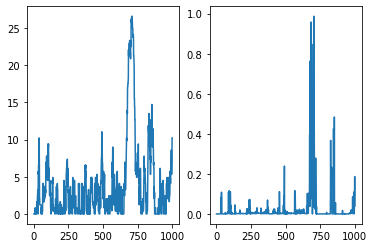

../data/driving_cycles/city\VITO_RW_Decade_Jumper_BCN_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 87.249
Episode: 191 Exploration P: 0.0119 Total reward: -289.10599687217956 SOC: 0.5754 Cumulative_SOC_deviation: 26.9623 Fuel Consumption: 19.4831

../data/driving_cycles/city\VITO_RW_Decade_Jumper_MOL_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 98.871
Episode: 192 Exploration P: 0.0118 Total reward: -230.36609290588785 SOC: 0.5954 Cumulative_SOC_deviation: 20.0785 Fuel Consumption: 29.5816

../data/driving_cycles/city\VITO_RW_Decade_Octavia_BCN_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 78.664
Episode: 193 Exploration P: 0.0118 Total reward: -69.95741034677202 SOC: 0.6033 Cumulative_SOC_deviation: 5.0102 Fuel Consumption: 19.8556

../data/driving_cycles/city\VITO_RW_Decade_Octavia_MOL_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 73.483
Episode: 194 Exploration P: 0.0117 Total reward: -144.02238436612632 SOC: 0.60

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -162.77008054520155 SOC: 0.5856 Cumulative_SOC_deviation: 14.6737 Fuel Consumption: 16.0329
******************* Test is done *****************



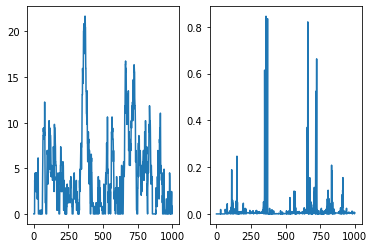

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 53.792
Episode: 201 Exploration P: 0.0114 Total reward: -56.71827028600543 SOC: 0.6004 Cumulative_SOC_deviation: 4.6783 Fuel Consumption: 9.9357

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 92.385
Episode: 202 Exploration P: 0.0113 Total reward: -223.60897487200452 SOC: 0.6042 Cumulative_SOC_deviation: 15.1051 Fuel Consumption: 72.5581

../data/driving_cycles/city\nuremberg_r36.mat
maximum steps, simulation is done ... 
elapsed_time: 53.299
Episode: 203 Exploration P: 0.0113 Total reward: -44.740240536664025 SOC: 0.6021 Cumulative_SOC_deviation: 3.2245 Fuel Consumption: 12.4956

../data/driving_cycles/city\ny_city_composite_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 50.593
Episode: 204 Exploration P: 0.0113 Total reward: -41.461783799337 SOC: 0.6092 Cumulative_SOC_deviation: 2.9810 Fuel Consumption: 11.6519

../data/

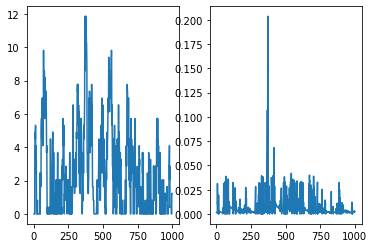

../data/driving_cycles/city\VITO_RW_BUS_VH_Brussels_Full_1.mat
maximum steps, simulation is done ... 
elapsed_time: 126.895
Episode: 211 Exploration P: 0.0110 Total reward: -114.6960737747717 SOC: 0.6008 Cumulative_SOC_deviation: 8.1157 Fuel Consumption: 33.5387

../data/driving_cycles/city\VITO_RW_BUS_VH_Brussels_Medium_1.mat
maximum steps, simulation is done ... 
elapsed_time: 110.463
Episode: 212 Exploration P: 0.0109 Total reward: -163.98228903787722 SOC: 0.5948 Cumulative_SOC_deviation: 13.1599 Fuel Consumption: 32.3830

../data/driving_cycles/city\VITO_RW_Decade_Jumper_BCN_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 86.957
Episode: 213 Exploration P: 0.0109 Total reward: -129.39999699315138 SOC: 0.6002 Cumulative_SOC_deviation: 10.9018 Fuel Consumption: 20.3818

../data/driving_cycles/city\VITO_RW_Decade_Jumper_MOL_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 98.011
Episode: 214 Exploration P: 0.0109 Total reward: -91.11689478051147 SOC: 0.597

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -42.30212041854434 SOC: 0.5996 Cumulative_SOC_deviation: 2.6288 Fuel Consumption: 16.0146
******************* Test is done *****************



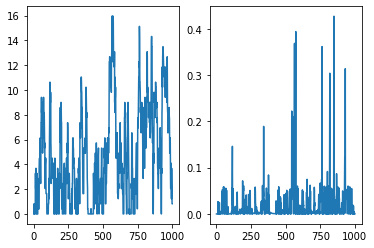

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 66.923
Episode: 221 Exploration P: 0.0107 Total reward: -146.3016112097035 SOC: 0.5987 Cumulative_SOC_deviation: 10.1312 Fuel Consumption: 44.9892

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 50.743
Episode: 222 Exploration P: 0.0107 Total reward: -138.54074463285903 SOC: 0.6018 Cumulative_SOC_deviation: 9.6675 Fuel Consumption: 41.8662

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 52.779
Episode: 223 Exploration P: 0.0107 Total reward: -42.998587603444456 SOC: 0.5997 Cumulative_SOC_deviation: 3.3547 Fuel Consumption: 9.4517

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 90.960
Episode: 224 Exploration P: 0.0106 Total reward: -195.44965222656302 SOC: 0.6039 Cumulative_SOC_deviation: 12.3378 Fuel Consumption: 72.0721

../data/drivin

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -120.42768559372458 SOC: 0.5904 Cumulative_SOC_deviation: 10.8116 Fuel Consumption: 12.3119
******************* Test is done *****************



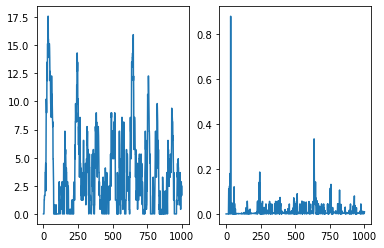

../data/driving_cycles/city\VITO_RW_BUS_TMB_Line24N_1.mat
maximum steps, simulation is done ... 
elapsed_time: 141.608
Episode: 231 Exploration P: 0.0105 Total reward: -183.56858392276266 SOC: 0.5988 Cumulative_SOC_deviation: 16.2411 Fuel Consumption: 21.1577

../data/driving_cycles/city\VITO_RW_BUS_VH_Brussels_Empty_1.mat
maximum steps, simulation is done ... 
elapsed_time: 102.834
Episode: 232 Exploration P: 0.0105 Total reward: -138.31820284119155 SOC: 0.6010 Cumulative_SOC_deviation: 10.3277 Fuel Consumption: 35.0414

../data/driving_cycles/city\VITO_RW_BUS_VH_Brussels_Full_1.mat
maximum steps, simulation is done ... 
elapsed_time: 126.784
Episode: 233 Exploration P: 0.0105 Total reward: -120.5064792821279 SOC: 0.6009 Cumulative_SOC_deviation: 8.7256 Fuel Consumption: 33.2507

../data/driving_cycles/city\VITO_RW_BUS_VH_Brussels_Medium_1.mat
maximum steps, simulation is done ... 
elapsed_time: 110.128
Episode: 234 Exploration P: 0.0105 Total reward: -106.42079394385671 SOC: 0.6001 C

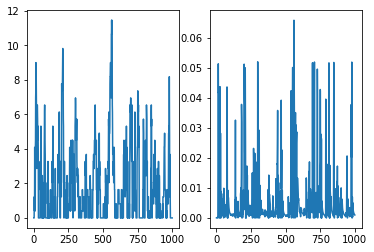

../data/driving_cycles/city\VITO_RW_Kangoo_DePost_Brussels_101_1.mat
maximum steps, simulation is done ... 
elapsed_time: 113.344
Episode: 241 Exploration P: 0.0103 Total reward: -98.23064830613365 SOC: 0.5956 Cumulative_SOC_deviation: 7.1141 Fuel Consumption: 27.0893

../data/driving_cycles/city\wvucity.mat
maximum steps, simulation is done ... 
elapsed_time: 61.189
Episode: 242 Exploration P: 0.0103 Total reward: -83.02195034089908 SOC: 0.6044 Cumulative_SOC_deviation: 6.7814 Fuel Consumption: 15.2081

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 59.750
Episode: 243 Exploration P: 0.0103 Total reward: -162.9059104756012 SOC: 0.5993 Cumulative_SOC_deviation: 11.7132 Fuel Consumption: 45.7743

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 46.319
Episode: 244 Exploration P: 0.0103 Total reward: -116.68236963996826 SOC: 0.6035 Cumulative_SOC_deviation: 7.3427 Fuel Consumption: 43.25

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -44.631893605562965 SOC: 0.5976 Cumulative_SOC_deviation: 3.4075 Fuel Consumption: 10.5569
******************* Test is done *****************



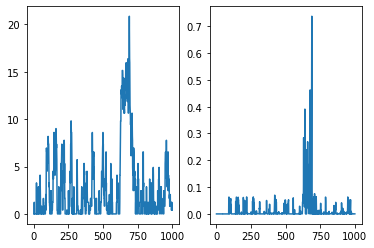

../data/driving_cycles/city\VITO_MOLCity.mat
maximum steps, simulation is done ... 
elapsed_time: 64.124
Episode: 251 Exploration P: 0.0103 Total reward: -88.72957066143373 SOC: 0.5995 Cumulative_SOC_deviation: 5.8348 Fuel Consumption: 30.3812

../data/driving_cycles/city\VITO_RW_Antwerp1_May19c.mat
maximum steps, simulation is done ... 
elapsed_time: 44.487
Episode: 252 Exploration P: 0.0103 Total reward: -31.873184910856462 SOC: 0.6013 Cumulative_SOC_deviation: 2.0549 Fuel Consumption: 11.3238

../data/driving_cycles/city\VITO_RW_BUS_TMB_Line24N_1.mat
maximum steps, simulation is done ... 
elapsed_time: 127.741
Episode: 253 Exploration P: 0.0103 Total reward: -64.76468201659212 SOC: 0.6009 Cumulative_SOC_deviation: 4.3591 Fuel Consumption: 21.1739

../data/driving_cycles/city\VITO_RW_BUS_VH_Brussels_Empty_1.mat
maximum steps, simulation is done ... 
elapsed_time: 92.044
Episode: 254 Exploration P: 0.0102 Total reward: -148.22239014110585 SOC: 0.5997 Cumulative_SOC_deviation: 11.2744 

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -50.94035778950853 SOC: 0.5990 Cumulative_SOC_deviation: 3.3881 Fuel Consumption: 17.0592
******************* Test is done *****************



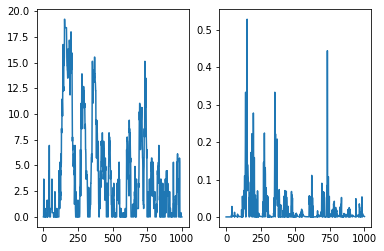

../data/driving_cycles/city\VITO_RW_Decade_Polo_BCN_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 63.832
Episode: 261 Exploration P: 0.0102 Total reward: -81.47475193615088 SOC: 0.5995 Cumulative_SOC_deviation: 5.6165 Fuel Consumption: 25.3101

../data/driving_cycles/city\VITO_RW_Jumper_Brussels_101_1.mat
maximum steps, simulation is done ... 
elapsed_time: 114.149
Episode: 262 Exploration P: 0.0102 Total reward: -91.41947826460645 SOC: 0.5983 Cumulative_SOC_deviation: 6.6998 Fuel Consumption: 24.4218

../data/driving_cycles/city\VITO_RW_Kangoo_DePost_Brussels_101_1.mat
maximum steps, simulation is done ... 
elapsed_time: 116.663
Episode: 263 Exploration P: 0.0102 Total reward: -116.74645997411947 SOC: 0.5963 Cumulative_SOC_deviation: 8.9502 Fuel Consumption: 27.2447

../data/driving_cycles/city\wvucity.mat
maximum steps, simulation is done ... 
elapsed_time: 61.033
Episode: 264 Exploration P: 0.0102 Total reward: -113.15659715286992 SOC: 0.6013 Cumulative_SOC_deviatio

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -46.235542792020574 SOC: 0.5951 Cumulative_SOC_deviation: 3.3192 Fuel Consumption: 13.0434
******************* Test is done *****************



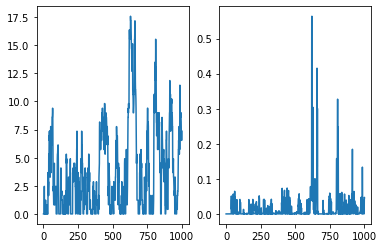

../data/driving_cycles/city\ny_city_traffic.mat
maximum steps, simulation is done ... 
elapsed_time: 26.114
Episode: 271 Exploration P: 0.0101 Total reward: -23.16595567488736 SOC: 0.5990 Cumulative_SOC_deviation: 1.7496 Fuel Consumption: 5.6703

../data/driving_cycles/city\VITO_DUBDC.mat
maximum steps, simulation is done ... 
elapsed_time: 39.076
Episode: 272 Exploration P: 0.0101 Total reward: -56.435190773878084 SOC: 0.6012 Cumulative_SOC_deviation: 3.8395 Fuel Consumption: 18.0399

../data/driving_cycles/city\VITO_MOLCity.mat
maximum steps, simulation is done ... 
elapsed_time: 64.726
Episode: 273 Exploration P: 0.0101 Total reward: -81.69257939389567 SOC: 0.6022 Cumulative_SOC_deviation: 5.1287 Fuel Consumption: 30.4054

../data/driving_cycles/city\VITO_RW_Antwerp1_May19c.mat
maximum steps, simulation is done ... 
elapsed_time: 44.830
Episode: 274 Exploration P: 0.0101 Total reward: -36.97924238847686 SOC: 0.6002 Cumulative_SOC_deviation: 2.5746 Fuel Consumption: 11.2330

../data/

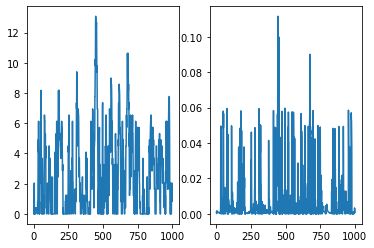

../data/driving_cycles/city\VITO_RW_Decade_Octavia_BCN_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 69.531
Episode: 281 Exploration P: 0.0101 Total reward: -75.47226174115131 SOC: 0.6004 Cumulative_SOC_deviation: 5.5681 Fuel Consumption: 19.7912

../data/driving_cycles/city\VITO_RW_Decade_Octavia_MOL_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 64.572
Episode: 282 Exploration P: 0.0101 Total reward: -153.8595344947352 SOC: 0.5923 Cumulative_SOC_deviation: 11.8699 Fuel Consumption: 35.1606

../data/driving_cycles/city\VITO_RW_Decade_Polo_BCN_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 63.654
Episode: 283 Exploration P: 0.0101 Total reward: -110.4079904061876 SOC: 0.6016 Cumulative_SOC_deviation: 8.4900 Fuel Consumption: 25.5080

../data/driving_cycles/city\VITO_RW_Jumper_Brussels_101_1.mat
maximum steps, simulation is done ... 
elapsed_time: 113.704
Episode: 284 Exploration P: 0.0101 Total reward: -80.2157537886488 SOC: 0.5991 Cumul

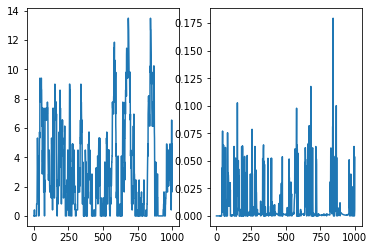

../data/driving_cycles/city\nuremberg_r36.mat
maximum steps, simulation is done ... 
elapsed_time: 46.855
Episode: 291 Exploration P: 0.0101 Total reward: -56.58540531531605 SOC: 0.5974 Cumulative_SOC_deviation: 4.4404 Fuel Consumption: 12.1810

../data/driving_cycles/city\ny_city_composite_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 44.518
Episode: 292 Exploration P: 0.0101 Total reward: -45.30552417218924 SOC: 0.6021 Cumulative_SOC_deviation: 3.4227 Fuel Consumption: 11.0783

../data/driving_cycles/city\ny_city_traffic.mat
maximum steps, simulation is done ... 
elapsed_time: 25.956
Episode: 293 Exploration P: 0.0101 Total reward: -30.667057941705277 SOC: 0.5984 Cumulative_SOC_deviation: 2.4998 Fuel Consumption: 5.6693

../data/driving_cycles/city\VITO_DUBDC.mat
maximum steps, simulation is done ... 
elapsed_time: 39.007
Episode: 294 Exploration P: 0.0101 Total reward: -74.03214667022245 SOC: 0.5978 Cumulative_SOC_deviation: 5.6305 Fuel Consumption: 17.7271

../data

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -47.22270374163892 SOC: 0.5969 Cumulative_SOC_deviation: 3.4590 Fuel Consumption: 12.6323
******************* Test is done *****************



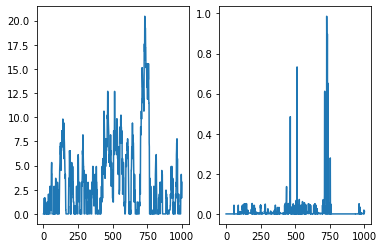

../data/driving_cycles/city\VITO_RW_Decade_Jumper_BCN_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 76.684
Episode: 301 Exploration P: 0.0100 Total reward: -78.24698345358914 SOC: 0.6003 Cumulative_SOC_deviation: 5.7834 Fuel Consumption: 20.4131

../data/driving_cycles/city\VITO_RW_Decade_Jumper_MOL_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 86.773
Episode: 302 Exploration P: 0.0100 Total reward: -101.53885583481731 SOC: 0.5953 Cumulative_SOC_deviation: 7.2825 Fuel Consumption: 28.7135

../data/driving_cycles/city\VITO_RW_Decade_Octavia_BCN_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 69.957
Episode: 303 Exploration P: 0.0100 Total reward: -75.2674650527133 SOC: 0.5990 Cumulative_SOC_deviation: 5.5647 Fuel Consumption: 19.6208

../data/driving_cycles/city\VITO_RW_Decade_Octavia_MOL_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 64.801
Episode: 304 Exploration P: 0.0100 Total reward: -120.87196921361458 SOC: 0.5985 C

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -22.551939624939337 SOC: 0.5999 Cumulative_SOC_deviation: 1.3381 Fuel Consumption: 9.1711
******************* Test is done *****************



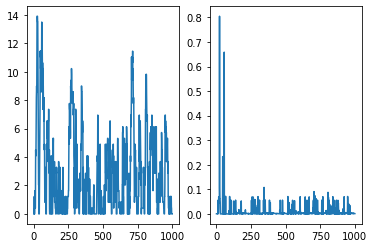

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 47.727
Episode: 311 Exploration P: 0.0100 Total reward: -33.50883178734192 SOC: 0.6007 Cumulative_SOC_deviation: 2.3636 Fuel Consumption: 9.8727

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 82.611
Episode: 312 Exploration P: 0.0100 Total reward: -179.61766912266816 SOC: 0.6041 Cumulative_SOC_deviation: 10.7301 Fuel Consumption: 72.3171

../data/driving_cycles/city\nuremberg_r36.mat
maximum steps, simulation is done ... 
elapsed_time: 47.376
Episode: 313 Exploration P: 0.0100 Total reward: -36.308241984819745 SOC: 0.6032 Cumulative_SOC_deviation: 2.3726 Fuel Consumption: 12.5824

../data/driving_cycles/city\ny_city_composite_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 44.656
Episode: 314 Exploration P: 0.0100 Total reward: -67.35262481470835 SOC: 0.6007 Cumulative_SOC_deviation: 5.5954 Fuel Consumption: 11.3986

../dat

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -32.49701218110379 SOC: 0.5972 Cumulative_SOC_deviation: 2.2281 Fuel Consumption: 10.2155
******************* Test is done *****************



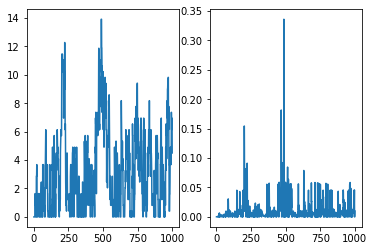

../data/driving_cycles/city\VITO_RW_BUS_VH_Brussels_Full_1.mat
maximum steps, simulation is done ... 
elapsed_time: 114.588
Episode: 321 Exploration P: 0.0100 Total reward: -111.25285692140358 SOC: 0.6013 Cumulative_SOC_deviation: 7.7975 Fuel Consumption: 33.2777

../data/driving_cycles/city\VITO_RW_BUS_VH_Brussels_Medium_1.mat
maximum steps, simulation is done ... 
elapsed_time: 99.351
Episode: 322 Exploration P: 0.0100 Total reward: -106.56229740790992 SOC: 0.5990 Cumulative_SOC_deviation: 7.3390 Fuel Consumption: 33.1721

../data/driving_cycles/city\VITO_RW_Decade_Jumper_BCN_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 76.876
Episode: 323 Exploration P: 0.0100 Total reward: -83.29969406763323 SOC: 0.6002 Cumulative_SOC_deviation: 6.2743 Fuel Consumption: 20.5565

../data/driving_cycles/city\VITO_RW_Decade_Jumper_MOL_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 87.327
Episode: 324 Exploration P: 0.0100 Total reward: -97.67826443105201 SOC: 0.5993 C

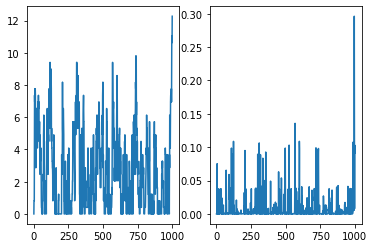

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 59.534
Episode: 331 Exploration P: 0.0100 Total reward: -151.99595791303145 SOC: 0.5975 Cumulative_SOC_deviation: 10.5704 Fuel Consumption: 46.2923

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 46.196
Episode: 332 Exploration P: 0.0100 Total reward: -131.54391961789412 SOC: 0.6007 Cumulative_SOC_deviation: 8.6138 Fuel Consumption: 45.4063

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 47.474
Episode: 333 Exploration P: 0.0100 Total reward: -32.5084132809661 SOC: 0.6018 Cumulative_SOC_deviation: 2.2888 Fuel Consumption: 9.6201

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 81.463
Episode: 334 Exploration P: 0.0100 Total reward: -243.05171809868344 SOC: 0.5889 Cumulative_SOC_deviation: 17.0108 Fuel Consumption: 72.9437

../data/driving

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -40.11078895573768 SOC: 0.5972 Cumulative_SOC_deviation: 2.9121 Fuel Consumption: 10.9900
******************* Test is done *****************



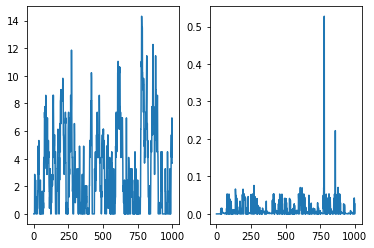

../data/driving_cycles/city\VITO_RW_BUS_TMB_Line24N_1.mat
maximum steps, simulation is done ... 
elapsed_time: 126.404
Episode: 341 Exploration P: 0.0100 Total reward: -88.81457539918368 SOC: 0.5990 Cumulative_SOC_deviation: 6.7078 Fuel Consumption: 21.7362

../data/driving_cycles/city\VITO_RW_BUS_VH_Brussels_Empty_1.mat
maximum steps, simulation is done ... 
elapsed_time: 91.773
Episode: 342 Exploration P: 0.0100 Total reward: -170.56180550569206 SOC: 0.5991 Cumulative_SOC_deviation: 13.4869 Fuel Consumption: 35.6930

../data/driving_cycles/city\VITO_RW_BUS_VH_Brussels_Full_1.mat
maximum steps, simulation is done ... 
elapsed_time: 113.291
Episode: 343 Exploration P: 0.0100 Total reward: -137.1431169503107 SOC: 0.6055 Cumulative_SOC_deviation: 10.3055 Fuel Consumption: 34.0879

../data/driving_cycles/city\VITO_RW_BUS_VH_Brussels_Medium_1.mat
maximum steps, simulation is done ... 
elapsed_time: 98.706
Episode: 344 Exploration P: 0.0100 Total reward: -139.64359440033184 SOC: 0.6005 Cumu

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -100.06548429143133 SOC: 0.5875 Cumulative_SOC_deviation: 8.4997 Fuel Consumption: 15.0684
******************* Test is done *****************



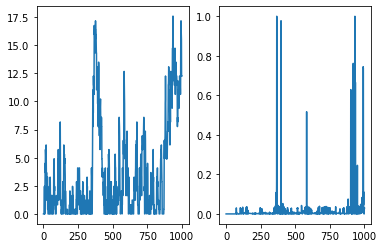

../data/driving_cycles/city\VITO_RW_Kangoo_DePost_Brussels_101_1.mat
maximum steps, simulation is done ... 
elapsed_time: 116.796
Episode: 351 Exploration P: 0.0100 Total reward: -85.55378468025215 SOC: 0.6001 Cumulative_SOC_deviation: 5.8244 Fuel Consumption: 27.3100

../data/driving_cycles/city\wvucity.mat
maximum steps, simulation is done ... 
elapsed_time: 61.080
Episode: 352 Exploration P: 0.0100 Total reward: -92.9234825594343 SOC: 0.5980 Cumulative_SOC_deviation: 7.8001 Fuel Consumption: 14.9220

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 59.532
Episode: 353 Exploration P: 0.0100 Total reward: -211.70923807211676 SOC: 0.5977 Cumulative_SOC_deviation: 16.4459 Fuel Consumption: 47.2499

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 46.072
Episode: 354 Exploration P: 0.0100 Total reward: -135.43173253942956 SOC: 0.6018 Cumulative_SOC_deviation: 8.9290 Fuel Consumption: 46.14

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -32.45368884367464 SOC: 0.5996 Cumulative_SOC_deviation: 2.0190 Fuel Consumption: 12.2638
******************* Test is done *****************



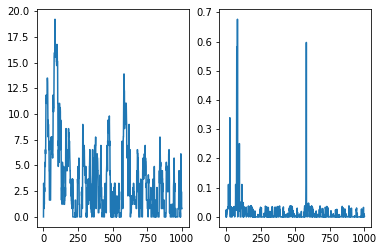

../data/driving_cycles/city\VITO_MOLCity.mat
maximum steps, simulation is done ... 
elapsed_time: 64.628
Episode: 361 Exploration P: 0.0100 Total reward: -107.36453892354615 SOC: 0.5938 Cumulative_SOC_deviation: 7.6500 Fuel Consumption: 30.8641

../data/driving_cycles/city\VITO_RW_Antwerp1_May19c.mat
maximum steps, simulation is done ... 
elapsed_time: 44.588
Episode: 362 Exploration P: 0.0100 Total reward: -44.31917060436282 SOC: 0.6005 Cumulative_SOC_deviation: 3.3106 Fuel Consumption: 11.2137

../data/driving_cycles/city\VITO_RW_BUS_TMB_Line24N_1.mat
maximum steps, simulation is done ... 
elapsed_time: 127.636
Episode: 363 Exploration P: 0.0100 Total reward: -64.82123698779115 SOC: 0.6033 Cumulative_SOC_deviation: 4.3200 Fuel Consumption: 21.6217

../data/driving_cycles/city\VITO_RW_BUS_VH_Brussels_Empty_1.mat
maximum steps, simulation is done ... 
elapsed_time: 92.607
Episode: 364 Exploration P: 0.0100 Total reward: -107.684043757031 SOC: 0.6001 Cumulative_SOC_deviation: 7.1947 Fue

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -36.57124940353286 SOC: 0.5992 Cumulative_SOC_deviation: 2.0198 Fuel Consumption: 16.3731
******************* Test is done *****************



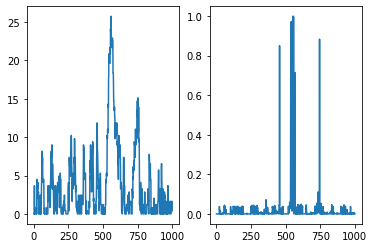

../data/driving_cycles/city\VITO_RW_Decade_Polo_BCN_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 64.042
Episode: 371 Exploration P: 0.0100 Total reward: -86.03317182821914 SOC: 0.6014 Cumulative_SOC_deviation: 6.0347 Fuel Consumption: 25.6861

../data/driving_cycles/city\VITO_RW_Jumper_Brussels_101_1.mat
maximum steps, simulation is done ... 
elapsed_time: 114.331
Episode: 372 Exploration P: 0.0100 Total reward: -66.50261859132362 SOC: 0.6023 Cumulative_SOC_deviation: 4.1803 Fuel Consumption: 24.6999

../data/driving_cycles/city\VITO_RW_Kangoo_DePost_Brussels_101_1.mat
maximum steps, simulation is done ... 
elapsed_time: 116.964
Episode: 373 Exploration P: 0.0100 Total reward: -73.07956671210397 SOC: 0.6034 Cumulative_SOC_deviation: 4.5669 Fuel Consumption: 27.4104

../data/driving_cycles/city\wvucity.mat
maximum steps, simulation is done ... 
elapsed_time: 61.253
Episode: 374 Exploration P: 0.0100 Total reward: -91.83737237923518 SOC: 0.6091 Cumulative_SOC_deviation:

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -40.90927686254394 SOC: 0.5994 Cumulative_SOC_deviation: 2.0311 Fuel Consumption: 20.5983
******************* Test is done *****************



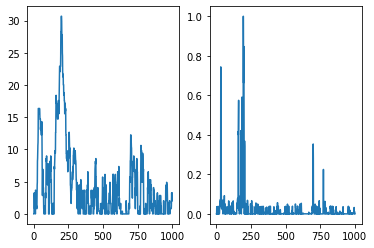

../data/driving_cycles/city\ny_city_traffic.mat
maximum steps, simulation is done ... 
elapsed_time: 26.056
Episode: 381 Exploration P: 0.0100 Total reward: -18.703500190801442 SOC: 0.6005 Cumulative_SOC_deviation: 1.2869 Fuel Consumption: 5.8346

../data/driving_cycles/city\VITO_DUBDC.mat
maximum steps, simulation is done ... 
elapsed_time: 39.028
Episode: 382 Exploration P: 0.0100 Total reward: -53.360703885210846 SOC: 0.6001 Cumulative_SOC_deviation: 3.5501 Fuel Consumption: 17.8593

../data/driving_cycles/city\VITO_MOLCity.mat
maximum steps, simulation is done ... 
elapsed_time: 64.617
Episode: 383 Exploration P: 0.0100 Total reward: -86.29922279397846 SOC: 0.5971 Cumulative_SOC_deviation: 5.5838 Fuel Consumption: 30.4610

../data/driving_cycles/city\VITO_RW_Antwerp1_May19c.mat
maximum steps, simulation is done ... 
elapsed_time: 44.665
Episode: 384 Exploration P: 0.0100 Total reward: -29.492816495122597 SOC: 0.6004 Cumulative_SOC_deviation: 1.8275 Fuel Consumption: 11.2178

../dat

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -43.0875995312843 SOC: 0.5989 Cumulative_SOC_deviation: 2.4411 Fuel Consumption: 18.6770
******************* Test is done *****************



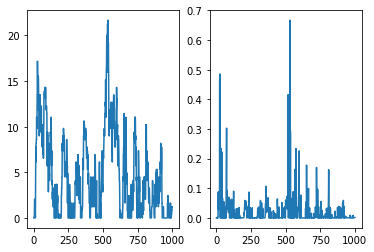

../data/driving_cycles/city\VITO_RW_Decade_Octavia_BCN_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 69.894
Episode: 391 Exploration P: 0.0100 Total reward: -62.12039109977141 SOC: 0.6029 Cumulative_SOC_deviation: 4.2479 Fuel Consumption: 19.6417

../data/driving_cycles/city\VITO_RW_Decade_Octavia_MOL_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 65.090
Episode: 392 Exploration P: 0.0100 Total reward: -83.5093889686778 SOC: 0.5995 Cumulative_SOC_deviation: 4.8555 Fuel Consumption: 34.9541

../data/driving_cycles/city\VITO_RW_Decade_Polo_BCN_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 63.828
Episode: 393 Exploration P: 0.0100 Total reward: -84.4643940433485 SOC: 0.6023 Cumulative_SOC_deviation: 5.9190 Fuel Consumption: 25.2744

../data/driving_cycles/city\VITO_RW_Jumper_Brussels_101_1.mat
maximum steps, simulation is done ... 
elapsed_time: 113.961
Episode: 394 Exploration P: 0.0100 Total reward: -69.55048186467293 SOC: 0.6012 Cumulat

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential\generalization_final\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -27.300119727613144 SOC: 0.5996 Cumulative_SOC_deviation: 1.6155 Fuel Consumption: 11.1451
******************* Test is done *****************



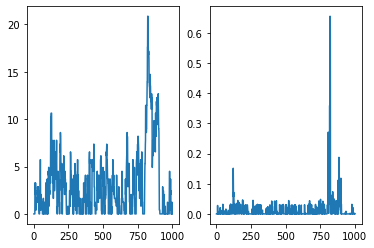

model is saved..


In [15]:
# print(env.version)

num_trials = 1
results_dict = {} 
driving_cycle_paths = glob.glob("../data/driving_cycles/city/*.mat")

for trial in range(num_trials): 
    print("")
    print("Trial {}".format(trial))
    print("")
    
    actor_model, critic_model, target_actor, target_critic, buffer = initialization()
    
    eps = MAX_EPSILON 
    steps = 0
    
    episode_rewards = [] 
    episode_SOCs = [] 
    episode_FCs = [] 
    episode_test_history = [] 
    episode_num_test = [] 
    for ep in range(total_episodes):
        i = ep % len(driving_cycle_paths)
        driving_cycle_path =driving_cycle_paths[i]
        print(driving_cycle_path)
        drv_cycle = sio.loadmat(driving_cycle_path)
        driving_cycle = drv_cycle["sch_cycle"][:, 1]

        env = initialization_env(driving_cycle, 10)
        
        start = time.time() 
        state = env.reset() 
        episodic_reward = 0 

        while True: 
            tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
            action = policy_epsilon_greedy(tf_state, eps)
    #         print(action)
            next_state, reward, done = env.step(action)
            if done: 
                next_state = [0] * num_states 

            buffer.record((state, action, reward, next_state))
            episodic_reward += reward 

            if steps > DELAY_TRAINING: 
                buffer.learn() 
                update_target(tau)
                eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-DECAY_RATE * (steps
                                                                        -DELAY_TRAINING))

            steps += 1

            if done: 
                break 

            state = next_state 

        elapsed_time = time.time() - start 
        print("elapsed_time: {:.3f}".format(elapsed_time))
        episode_rewards.append(episodic_reward) 
        episode_SOCs.append(env.SOC)
        episode_FCs.append(env.fuel_consumption) 

    #     print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
        SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
        print(
              'Episode: {}'.format(ep + 1),
              "Exploration P: {:.4f}".format(eps),
              'Total reward: {}'.format(episodic_reward), 
              "SOC: {:.4f}".format(env.SOC), 
              "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
              "Fuel Consumption: {:.4f}".format(env.fuel_consumption), 
        )
        print("")
        
        if (ep + 1) % 10 == 0: 
            history = test_agent(actor_model, 10)
            episode_test_history.append(history) 
            episode_num_test.append(ep + 1)
            
          
    root = "DDPG_reference_trained_all_mass1200"
    save_weights(actor_model, critic_model, target_actor, target_critic, root)
    
    results_dict[trial + 1] = {
        "rewards": episode_rewards, 
        "SOCs": episode_SOCs, 
        "FCs": episode_FCs, 
        "test_history": episode_test_history, 
        "test_episode_num": episode_num_test, 
    }

In [16]:
with open("DDPG_reference_all_mass1200.pkl", "wb") as f: 
    pickle.dump(results_dict, f, pickle.HIGHEST_PROTOCOL)

In [17]:
# results_dict